## Antithetic and Geometric Control Variate Variance Reduction for Arithmetic Asian Call Options ##

In [21]:
# Imports:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

#Import helper functions for MC/RQMC methods, GBM path generation, and asian option payoffs:
import asian, paths, lds

In [22]:
# # Experiment parameters:
BASE_SEED = 123
S0, K, r, sigma, T = 100.0, 100.0, 0.02, 0.20, 10.0
d = 20                # monitoring dates
n_paths = 2**7         # paths per replicate
RQMC_R_LIST = [16]

# Brownian-bridge precomputation:
precomp = paths.precompute_all(T, d)

## Price Estimation of the Arithmetic Asian Call Option

In this notebook, we consider the **price estimation of the arithmetic Asian call option**, given:

- Spot price: $S_0$ at initial time $t_0 = 0$
- Monitoring times: $\{ t_1, \ldots, t_d = T \}$
- Strike price: $K$
- Asset dynamics: $S_t$ following a GBM with interest rate $r$ and volatility $\sigma$

The payoff is given by:

$$
\max\{ A_T - K, 0 \}, \quad \text{where} \quad A_T = \frac{1}{d} \sum_{i=1}^d S_{t_i}.
$$

---

### **Closed-form vs Simulation-based Pricing**

Differently from the **geometric Asian option** treated in the *Timed_Convergence_Analysis* notebook,  
this multi-look (path-dependent) option **does not have a closed-form fair value** under the Black–Scholes model.

However, we can estimate its price via **Monte Carlo (MC)** and **quasi Monte Carlo (QMC)** methods.  
Here, we further improve convergence using the following two **variance reduction techniques**:

---

### **1. Antithetic Variate**

Let

$$
\widehat{f}^{\text{Ari}}(S) = \widehat{f}^{\text{Ari}}(S^1, \ldots, S^n) = \frac{1}{n} \sum_{i=1}^n f^{\text{Ari}}(S^i)
$$

be the empirical approximation (MC or QMC) of the fair price of the option computing the arithmetic payoff $f^{\text{Ari}}$ on the collection $S$ of $n$ simulated GBM paths  
$S^i = (S_{t_1}^i, \ldots, S_{t_d}^i)$.

We then introduce the **antithetic path**  
$S^{\text{ant},i} = (S_{t_1}^{\text{ant},i}, \ldots, S_{t_d}^{\text{ant},i})$,  
which is generated using the same construction method as $S^i$ (standard, PCA, or Brownian bridge),  
but with **flipped signs** of the normal increments $Z_1, \ldots, Z_d$.

The corresponding estimator of the fair value price becomes:

$$
\frac{1}{2} \Big(
\widehat{f}^{\text{Ari}}(S^1, \ldots, S^n)
+
\widehat{f}^{\text{Ari}}(S^{\text{ant},1}, \ldots, S^{\text{ant},n})
\Big).
$$

---

### **2. Geometric Control Variate**

With this method, the fair price estimator becomes:

$$
\widehat{f}(S) + b^* \Big( \mathbb{E}[\widehat{f}^{\text{Geom}}(S)] - \widehat{f}^{\text{Geom}}(S) \Big),
$$

where $\widehat{f}^{\text{Geom}}$ is the empirical approximation of the **geometric Asian option price** computed evaluating the corresponding payoff function $f^{\text{Geom}}$,
used as a **control variate** for the arithmetic Asian option.

The optimal control variate parameter $b^*$ is approximated empirically as:

$$
b^* =
\frac{
\sum_{i=1}^n \big( f(S^i) - \widehat{f} \big)
      \big( f^{\text{Geom}}(S^i) - \widehat{f}^{\text{Geom}}(S) \big)
}{
\sum_{i=1}^n \big( f^{\text{Geom}}(S^i) - \widehat{f}^{\text{Geom}}(S) \big)^2
}.
$$

Note that the expected value $\mathbb{E}[\widehat{f}^{\text{Geom}}(S)]$ in this case corresponds to  
the **fair value of the geometric Asian option**, which can be computed **in closed form** in the Black–Scholes world.


In [23]:
def build_paths_from_Z(Z):
    return paths.generate_paths(
        method='bridge', S0=S0, r=r, sigma=sigma, T=T, d=d, Z=Z, precomp=precomp
    )

def payoff_arith(S):
    return asian.asian_payoff_paths(S, K=K, r=r, T=T, option="call",
                                    average='arith')

def payoff_geom(S):
    return asian.asian_payoff_paths(S, K=K, r=r, T=T, option="call",
                                    average='geom')

GEOM_CF = asian.geometric_asian_call_price_discrete(
    S0=S0, K=K, r=r, sigma=sigma, T=T, d=d)

def antithetic_average(Z):
    S_plus  = build_paths_from_Z(Z)
    S_minus = build_paths_from_Z(-Z)
    A_plus  = payoff_arith(S_plus)
    A_minus = payoff_arith(S_minus)
    return 0.5 * (A_plus + A_minus)

def antithetic_average_both(Z):
    S_plus  = build_paths_from_Z(Z)
    S_minus = build_paths_from_Z(-Z)
    A_bar = 0.5 * (payoff_arith(S_plus) + payoff_arith(S_minus))
    G_bar = 0.5 * (payoff_geom(S_plus)  + payoff_geom(S_minus))
    return A_bar, G_bar

def cv_adjust(prices, cv_samples, cv_expectation):
    y = cv_samples - cv_samples.mean()
    x = prices     - prices.mean()
    var_y = np.mean(y*y)
    b_star = 0.0 if var_y <= 0 else np.mean(x*y)/var_y
    adjusted = prices - b_star*(cv_samples - cv_expectation)
    return adjusted, b_star

### **Impact of Variance Reduction Techniques**

We next examine how the **variance reduction techniques** affect both the **Monte Carlo (MC)** and **randomized quasi Monte Carlo (RQMC)** estimates of the **arithmetic Asian call option** price.  
In this analysis, we use the **Brownian Bridge construction** with **$R = 16$ replicates**.


In [24]:
# MC method:
def mc_run(n, antithetic=False, geometric_cv=False, seed=None):
    U = lds.prn_uniform(n, d, seed=seed)   
    Z = lds.u_to_normal(U)                 
    if antithetic and geometric_cv:
        A_bar, G_bar = antithetic_average_both(Z)
        adj, b_star = cv_adjust(A_bar, G_bar, GEOM_CF)
        est, se = adj.mean(), adj.std(ddof=1)/np.sqrt(len(adj))
        return est, se, {'b*': b_star, 'n': len(adj)}
    elif antithetic:
        A_bar = antithetic_average(Z)
        est, se = A_bar.mean(), A_bar.std(ddof=1)/np.sqrt(len(A_bar))
        return est, se, {'n': len(A_bar)}
    elif geometric_cv:
        S = build_paths_from_Z(Z)
        A, G = payoff_arith(S), payoff_geom(S)
        adj, b_star = cv_adjust(A, G, GEOM_CF)
        est, se = adj.mean(), adj.std(ddof=1)/np.sqrt(len(adj))
        return est, se, {'b*': b_star, 'n': len(adj)}
    else:
        S = build_paths_from_Z(Z)
        A = payoff_arith(S)
        est, se = A.mean(), A.std(ddof=1)/np.sqrt(len(A))
        return est, se, {'n': len(A)}

mc_rows = []
for ant in [False, True]:
    for cv in [False, True]:
        est, se, info = mc_run(n_paths, antithetic=ant, geometric_cv=cv,
                               seed=BASE_SEED + ant + 10*cv)
        mc_rows.append({
            'Method':'MC',
            'Variance-Reduction': ('None' if (not ant and not cv)
                                   else 'Antithetic' if ant and not cv
                                   else 'GeomCV' if cv and not ant
                                   else 'Antithetic + GeomCV'),
            'Replicates R': 1,
            'n_paths per replicate': info.get('n', n_paths),
            'Mean': float(est),
            'Std': float(se),
            **({'b* (if GeomCV and R=1)': float(info.get('b*', np.nan))})
        })
mc_df = pd.DataFrame(mc_rows)

# RQMC Brownian Bridge method:
def qmc_replicate_mean(base_U, shift_seed, antithetic=False, geometric_cv=False):
    U_shift = lds.random_digital_shift(base_U, seed=shift_seed)
    Z = lds.u_to_normal(U_shift)
    if antithetic and geometric_cv:
        A_bar, G_bar = antithetic_average_both(Z)
        adj, b_star = cv_adjust(A_bar, G_bar, GEOM_CF)
        return float(adj.mean()), b_star
    elif antithetic:
        A_bar = antithetic_average(Z)
        return float(A_bar.mean()), np.nan
    elif geometric_cv:
        S = build_paths_from_Z(Z)
        A, G = payoff_arith(S), payoff_geom(S)
        adj, b_star = cv_adjust(A, G, GEOM_CF)
        return float(adj.mean()), b_star
    else:
        S = build_paths_from_Z(Z)
        A = payoff_arith(S)
        return float(A.mean()), np.nan

def qmc_run(n, R, antithetic=False, geometric_cv=False, seed=None):
    base_U = lds.sobol_points(n=n, d=d, scramble=False, seed=seed)
    means, bstars = [], []
    for r in range(R):
        m, b = qmc_replicate_mean(base_U, shift_seed=(seed or 0)+1000+r,
                                  antithetic=antithetic, geometric_cv=geometric_cv)
        means.append(m); bstars.append(b)
    means = np.array(means, float)
    bstars = np.array(bstars, float)
    est = float(means.mean())
    std = float(means.std(ddof=1)) if R > 1 else 0.0
    return est, std, {'R': R, 'n': n, 'b_stars_mean': (float(np.nanmean(bstars)) if geometric_cv else np.nan)}

qmc_rows = []
for R in RQMC_R_LIST:
    for ant in [False, True]:
        for cv in [False, True]:
            est, stR, info = qmc_run(n_paths, R=R, antithetic=ant, geometric_cv=cv,
                                     seed=BASE_SEED + R + 10*ant + 100*cv)
            qmc_rows.append({
                'Method':'RQMC (bridge)',
                'Variance-Reduction': ('None' if (not ant and not cv)
                                       else 'Antithetic' if ant and not cv
                                       else 'GeomCV' if cv and not ant
                                       else 'Antithetic + GeomCV'),
                'Replicates R': R,
                'n_paths per replicate': n_paths,
                'Mean': float(est),
                'Std': float(stR),
                'mean b* (if GeomCV and R>1)': float(info['b_stars_mean'])
            })
qmc_df = pd.DataFrame(qmc_rows)

summary_df = pd.concat([mc_df, qmc_df], ignore_index=True)
summary_df = summary_df[['Method','Variance-Reduction','Replicates R','n_paths per replicate','Mean','Std']
                        + [c for c in summary_df.columns if 'b*' in c]]
summary_df.sort_values(['Method','Replicates R','Variance-Reduction'], inplace=True, ignore_index=True)

print(f"Closed-form geometric Asian (control): {GEOM_CF:.6f}")
summary_df


Closed-form geometric Asian (control): 16.027379


,Method,Variance-Reduction,Replicates R,n_paths per replicate,Mean,Std,b* (if GeomCV and R=1),mean b* (if GeomCV and R>1)
0,MC,Antithetic,1,128,19.347618,1.459678,NaN,NaN
1,MC,Antithetic + GeomCV,1,128,18.390132,0.198007,1.116291,NaN
2,MC,GeomCV,1,128,18.211661,0.220735,1.107807,NaN
3,MC,None,1,128,14.714135,2.158316,NaN,NaN
4,RQMC (bridge),Antithetic,16,128,17.997223,0.635903,NaN,NaN
5,RQMC (bridge),Antithetic + GeomCV,16,128,18.211292,0.127033,NaN,1.131762
6,RQMC (bridge),GeomCV,16,128,18.203494,0.160889,NaN,1.130927
7,RQMC (bridge),None,16,128,18.313814,0.928195,NaN,NaN


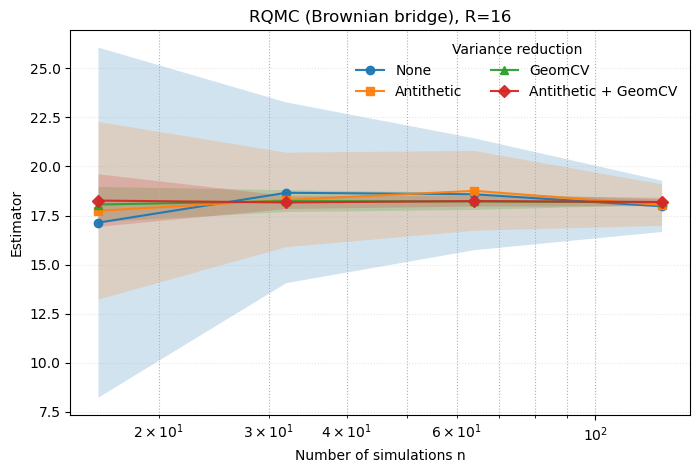

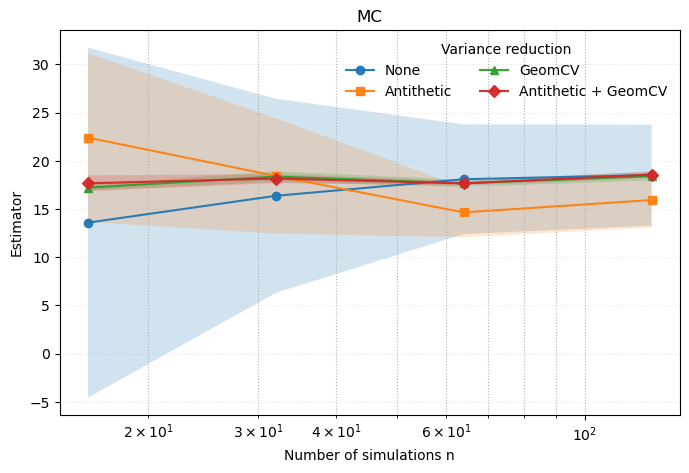

In [25]:
n_list = [2**4,2**5, 2**6, 2**7]   
R_RQMC = 16                         
seed_base = 12345                   

vr_configs = [
    ('None',                dict(antithetic=False, geometric_cv=False)),
    ('Antithetic',          dict(antithetic=True,  geometric_cv=False)),
    ('GeomCV',              dict(antithetic=False, geometric_cv=True)),
    ('Antithetic + GeomCV', dict(antithetic=True,  geometric_cv=True)),
]
vr_labels = [lab for lab, _ in vr_configs]

vr_markers = {
    'None': 'o',
    'Antithetic': 's',
    'GeomCV': '^',
    'Antithetic + GeomCV': 'D',
}

def ci_halfwidth(std_like):
    return 1.96 * np.asarray(std_like, dtype=float)

def collect_by_n(method, n_values, seed_base=12345):
    """
    Calls mc_run / qmc_run across n for each variance-reduction config.
    """
    results = {}
    for label, flags in vr_configs:
        xs, means, stds = [], [], []
        for i, n in enumerate(n_values):
            seed = seed_base + 1000*i 
            if method == 'MC':
                est, std_like, _info = mc_run(n=n, seed=seed, **flags)
            elif method == 'RQMC':
                est, std_like, _info = qmc_run(n=n, R=R_RQMC, seed=seed, **flags)
            else:
                raise ValueError("method must be 'MC' or 'RQMC'")
            xs.append(n)
            means.append(float(est))
            stds.append(float(std_like))
        results[label] = (np.array(xs, int), np.array(means, float), np.array(stds, float))
    return results

def plot_with_bands(ax, results_dict, title):
    """
    For each VR variant: plot mean line and a ±95% CI band via fill_between.
    """
    ax.set_title(title)
    ax.set_xlabel('Number of simulations n')
    ax.set_ylabel('Estimator')
    ax.grid(True, axis='y', alpha=0.3)

    for label in vr_labels:
        if label not in results_dict:
            continue
        x, y, s = results_dict[label]
        e = ci_halfwidth(s)

        ax.plot(x, y, marker=vr_markers.get(label, 'o'), linestyle='-', label=label, alpha=0.95)
        ax.fill_between(x, y - e, y + e, alpha=0.2, linewidth=0)

    ax.set_xticks(n_list)
    ax.legend(title='Variance reduction', frameon=False, ncol=2)

rqmc_res = collect_by_n('RQMC', n_list, seed_base=seed_base)
mc_res   = collect_by_n('MC',   n_list, seed_base=seed_base)

fig1, ax1 = plt.subplots(figsize=(8, 5))
plot_with_bands(ax1, rqmc_res, f'RQMC (Brownian bridge), R={R_RQMC}')
plt.xscale('log')
plt.grid(True, which='both', ls=':')

fig2, ax2 = plt.subplots(figsize=(8, 5))
plot_with_bands(ax2, mc_res, 'MC')
plt.xscale('log')
plt.grid(True, which='both', ls=':')
plt.show()


### **Analysis of Variance Reduction Results**

From the results collected in the table above, we confirm that, whether using **Monte Carlo (MC)** or **randomized quasi Monte Carlo (RQMC)** methods, the **antithetic** and **geometric control variate** estimators produce **more accurate** and **less noisy** results (i.e., lower standard deviations).

The **geometric control variate** achieves the **highest variance reduction**, owing to the **strong correlation** between the geometric and arithmetic Asian option prices.
